In [18]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *

from redTools import *
from Kcorrect import *


from matplotlib import rcParams
rcParams["font.size"] = 14
rcParams["text.usetex"] = True
rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"

####################################### Set Axes
def set_axes(ax_list, xlim, ylim):
    for ax in ax_list:
        
        ax.set_ylim(ylim)
        ax.set_xlim(xlim) 
        ax.tick_params(which='major', length=6, width=1.5, direction='in')
        ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')  

        y_ax = ax.twinx()
        y_ax.set_ylim(ylim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

        x_ax = ax.twiny()
        x_ax.set_xlim(xlim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=6, width=1.0, direction='in')
        x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
####################################### Plotting Function

In [19]:
inFile = 'corrected_mags_linewidth_all.csv'

table   = np.genfromtxt(inFile , delimiter='|', filling_values=-99999, names=True, dtype=None, encoding=None)

pgc  = table['pgc']
Sqlt = table['Sqlt']
Wqlt = table['Wqlt']

P0_w2 = table['P0_w2']
P0_w1 = table['P0_w1']


### First, I test if the cataloged P1_w1 and P2_w2 are consistent with that reproted in our reddening paper
Please note that in the following I have not considerred the error bars, for the paper I ahve considerred the error bars and I have got:
 - m = 1.021
 - b = -0.094

1.0193216418684727 -0.06788717201233271


(-3.5, 3.5)

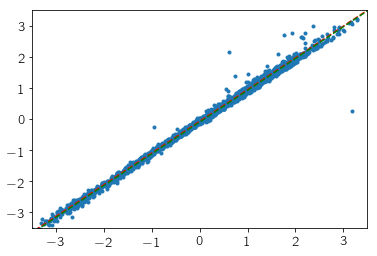

In [20]:
N = len(Sqlt)
q = np.zeros(N)

q[np.where(Sqlt>3)]+=1
q[np.where(Wqlt>3)]+=1
indx, = np.where(q==2)


PC_w1 = P0_w1[indx]
PC_w2 = P0_w2[indx]
N = len(PC_w2)
err = np.zeros(N)+0.01

M,B,samples=linMC(PC_w1, PC_w2, err, err)
m = M[0] ; me=0.5*(M[1]+M[2])
b = B[0] ; be=0.5*(B[1]+B[2])

plt.plot(PC_w1,PC_w2, '.') 
x_ = np.linspace(-4,15,50)
plt.plot(x_, m*x_+b, 'r--') 

plt.plot(x_, 1.021*x_-0.094, 'g--') 
print m,b

plt.xlim(-3.5,3.5)
plt.ylim(-3.5,3.5)

### Now let's look for low quality data, those galaxies with poor WISE photometry

In [35]:
N = len(Wqlt)
q = np.zeros(N)

q[np.where(Wqlt==3)]+=1
q[np.where(Wqlt==2)]+=1
indx, = np.where(q==1)
pgc_sub = pgc[indx]    # poor WISE photometry

Sqlt_sub = Sqlt[indx]  # poor WISE but good SDSS
indx, = np.where(Sqlt_sub>2)
pgc_sub_sdss = pgc_sub[indx]

pgc_sub_wise = np.asarray([idd for idd in pgc_sub if not idd in pgc_sub_sdss])
print len(pgc_sub)        # poor WISE photometry        
print len(pgc_sub_sdss)   # poor WISE but good SDSS         --> use the predicted values 
print len(pgc_sub_wise)   # poor WISE but and NO good SDSS  --> use P1_w1 for reddening correction

436
137
299


### Let's look for good/excellent WISE photometry (Wqlt>3), but users warn us about bad W2 data.
In this case we use W1, not the predicted vlaue, since W1 still looks good.

In [45]:
inFile  = '../EDD_distance_cf4_v26.csv'
table   = np.genfromtxt(inFile , delimiter='|', filling_values=-1, names=True, dtype=None)

pgc_ESN = table['pgc']
note    = table['note']

for i, text in enumerate(note):
    if pgc_ESN[i] in pgc:
        for word in text.split(' '):
            if 'W2' == word or 'w2' == word:
                print pgc_ESN[i], text
                break


/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  


3543                                                                    w1 is ok, background issue with w2 
7247                                                                      W1, W2 g.c. ok; W3 g.c. not good 
7824                                                                                        bad w2 profile 
8082                                                                  w1 seems to be good, w2 is uncertain 
9702                                                                      W1, W2 g.c. ok; very faint in W3 
10048                                                                       artifacts in W3; W1, W2 g.c. ok 
13154                                                                                    W2 g.c. dips a lot 
14304                                                                  w1 is fine, w2 seems to be uncertain 
14936                                                                               strange W2 growth curve 
16517                   

### Looking at the treasures users left when they did photometry
Here, I am looking at the flags users raised when they were dealing with WISE photometry. Specifically I'm looking for any anomally regarding W2 badn photometries. 

In [54]:
inFile = '../wise_all.csv'
table = np.genfromtxt( inFile , delimiter=',', filling_values=None, names=True, dtype=None)
wise_name = table['ID']
wise_pgc  = table['PGC']
#################
def QA_WISE_DONE(pgc, ra):
    
    global wise_name, wise_pgc
    
    databse = '/home/ehsan/db_esn/'+'/cf4_wise/data/'
    
    if pgc in wise_pgc:
        i_lst = np.where(pgc == wise_pgc)
        name = wise_name[i_lst][0] 
        if os.path.exists(databse+ra_db(ra)+'/wise/fits/'+name+'_qa.txt'):
            return True
    
    name = 'pgc'+str(pgc)
    if os.path.exists(databse+ra_db(ra)+'/wise/fits/'+name+'_qa.txt'):
         return True
        
    return False    
     
#################################
#################################
def ra_db(ra):   # returns a string
  
     ra_id = str(int(np.floor(ra)))
     if ra < 10:
       ra_id = '00'+ra_id+'D'
     elif ra < 100:
       ra_id = '0'+ra_id+'D'
     else:
       ra_id = ra_id+'D'
  
     return ra_id
#################################
def get_quality(filename, nline=40):
    line_no = 0
    seprator = ' '
    for line in open(filename, 'r'):
        columns = line.split(seprator)
        line_no+=1
        if len(columns) >= 2 and line_no==nline:
            key  = columns[0]
            j = 1
            while columns[j] == '' or columns[j] == '=': j+=1
            return int(columns[j])
    return -1
#################################
location  = '/home/ehsan/db_esn/cf4_wise/data/'

inFile  = '../EDD_distance_cf4_v26.csv'
table   = np.genfromtxt(inFile , delimiter='|', filling_values=None, names=True, dtype=None)
pgc_    = table['pgc']
ra_     = table['ra']

pgc_W2_poor_flags = []

for i in range(len(pgc_)):
    if pgc_[i] in pgc:
            
            found = False
            if QA_WISE_DONE(pgc_[i], ra_[i]):
                    found = True
                    radb = ra_db(ra_[i])
                    if pgc_[i] in wise_pgc:
                        i_lst = np.where(wise_pgc == pgc_[i])
                        galname = wise_name[i_lst][0]
                        qa_txt = location + radb + '/wise/fits/' + galname+'_qa.txt'
                    else:
                        galname = 'pgc'+str(pgc_[i])
                        qa_txt = location + radb + '/wise/fits/' + galname+'_qa.txt'
                        
                    if not os.path.exists(qa_txt):    
                        galname = 'pgc'+str(pgc_[i])
                        qa_txt = location + radb + '/wise/fits/' + galname+'_qa.txt'
                    
                    if not os.path.exists(qa_txt):
                        found = False

            if not found:
                continue  
                

            BAND2_EDGE     = get_quality(qa_txt, nline=30)
            BAND2_SN_GRAD  = get_quality(qa_txt, nline=31)
            BAND2_ARTIFACT = get_quality(qa_txt, nline=32)
            BAND2_OTHER    = get_quality(qa_txt, nline=33)
            BAND2_MISSING  = get_quality(qa_txt, nline=34)

            if BAND2_EDGE+BAND2_SN_GRAD+BAND2_ARTIFACT+BAND2_ARTIFACT+BAND2_OTHER+BAND2_MISSING>0:
                string = ''
                if BAND2_EDGE>0: string+='BAND2_EDGE'+' '
                if BAND2_SN_GRAD>0: string+='BAND2_SN_GRAD'+' '
                if BAND2_ARTIFACT>0: string+='BAND2_ARTIFACT'+' '
                if BAND2_OTHER>0: string+='BAND2_OTHER'+' '
                if BAND2_MISSING>0: string+='BAND2_MISSING'
                print pgc_[i], string
                pgc_W2_poor_flags.append(pgc_[i])
                continue

            
pgc_W2_poor_flags = np.asarray(pgc_W2_poor_flags)

/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:54: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.


181 BAND2_SN_GRAD 
496 BAND2_OTHER 
1525 BAND2_ARTIFACT 
1861 BAND2_SN_GRAD 
2134 BAND2_ARTIFACT 
2207 BAND2_OTHER 
2268 BAND2_ARTIFACT 
2553 BAND2_OTHER 
3543 BAND2_SN_GRAD 
4539 BAND2_OTHER 
5220 BAND2_OTHER 
5534 BAND2_OTHER 
7254 BAND2_ARTIFACT 
7281 BAND2_OTHER 
7819 BAND2_OTHER 
7824 BAND2_OTHER 
8082 BAND2_OTHER 
8335 BAND2_OTHER 
9788 BAND2_ARTIFACT 
9904 BAND2_ARTIFACT 
10496 BAND2_ARTIFACT 
10507 BAND2_SN_GRAD 
11856 BAND2_ARTIFACT 
14304 BAND2_OTHER 
18915 BAND2_OTHER 
19998 BAND2_OTHER 
20112 BAND2_OTHER 
20352 BAND2_OTHER 
22446 BAND2_OTHER 
24930 BAND2_ARTIFACT 
28511 BAND2_ARTIFACT 
28955 BAND2_OTHER 
31238 BAND2_OTHER 
32192 BAND2_ARTIFACT 
32648 BAND2_ARTIFACT 
35097 BAND2_ARTIFACT 
35202 BAND2_OTHER 
36699 BAND2_ARTIFACT 
37870 BAND2_SN_GRAD 
39845 BAND2_OTHER 
39886 BAND2_ARTIFACT 
40566 BAND2_ARTIFACT 
41729 BAND2_ARTIFACT 
42081 BAND2_ARTIFACT 
42089 BAND2_ARTIFACT 
44182 BAND2_ARTIFACT 
45701 BAND2_SN_GRAD 
46246 BAND2_SN_GRAD 
50322 BAND2_SN_GRAD 
52103 BAND2_SN_

### For these W2-flagged galaxies:
 - if Wqlt>3: use W1 band data for reddening correction
 - otherwise user SDSS predictions if available
 - otherwise stick to W1

In [55]:
print len(pgc_W2_poor_flags)




84


### Prepare final list (all have poor W2 WISE photometry)
 - a list of PGC numbers where we should use W1
 - a list of PGC numbers where we should use SDSS predictions